# Hierarchical Model Comparison for Cognitive Models

Part 2: Hierarchical Model Comparison

by Lasse Elsemüller

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Generative-Model-Definition" data-toc-modified-id="Generative-Model-Definition-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generative Model Definition</a></span><ul class="toc-item"><li><span><a href="#Hyperpriors-and-Priors" data-toc-modified-id="Hyperpriors-and-Priors-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Hyperpriors and Priors</a></span></li><li><span><a href="#Creating-the-Simulators" data-toc-modified-id="Creating-the-Simulators-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Creating the Simulators</a></span></li><li><span><a href="#Prior-Predictive-Checks" data-toc-modified-id="Prior-Predictive-Checks-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Prior Predictive Checks</a></span></li></ul></li><li><span><a href="#Defining,-Training-&amp;-Validating-the-Neural-Approximator" data-toc-modified-id="Defining,-Training-&amp;-Validating-the-Neural-Approximator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Defining, Training &amp; Validating the Neural Approximator</a></span></li><li><span><a href="#Network-Application" data-toc-modified-id="Network-Application-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Network Application</a></span></li></ul></div>

In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from scipy import stats

import bayesflow as bf

In [2]:
# Confirm that GPU is available for training
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Introduction 

This is the second part of the tutorial series covering amortized model comparison with BayesFlow! The general workflow, the scenario and the cognitive models were introduced in [Part 1](./Model_Comparison_MPT.ipynb) and are assumed to be known, so here we will focus on the new elements introduced when comparing hierarchical models.

In [Part 1](./Model_Comparison_MPT.ipynb), we only conducted model comparison for a single participant at a time. Let us now consider all participants and their nested observations simultaneously in our model comparison!

## Generative Model Definition

To extend our MPT models to hierarchical ones, we need to introduce a superordinate level that encodes our assumptions about the relationships between individuals. We use the most popular hierarchical MPT framework, the latent-trait approach by [Klauer (2010)](https://link.springer.com/article/10.1007/s11336-009-9141-0). Here, we replace our non-hierarchical Beta priors by a multivariate normal distribution, which allows us to model correlations between our parameters. We afterwards use the cumulative distribution function of the standard normal distribution, $\Phi$, to transform from the real-line to probabilities. Let's write out our new model components explicitly with $m \in M$ denoting the participants:

$$
\begin{align}
\left[ \begin{array}{l} d_m' \\ g_m' \end{array} \right] 
&\sim \mathcal{N} \left( 
\left[\begin{array}{l} \mu_{d} \\ \mu_{g} \end{array} \right], \Sigma
\right) \text{ for } m=1,\dots,M\\
d_m &= \Phi(d_m') \text{ for } m=1,\dots,M\\
g_m &= \Phi(g_m') \text{ for } m=1,\dots,M\\
\end{align}
$$

### Hyperpriors and Priors

We now have to define hyperpriors for the parameters of the multivariate normal prior distribution. For the covariance matrix $\Sigma$, the latent-trait approach employs a scaled inverse Wishart distribution. The $Q$ parameter controls the correlation between our parameters $d$ and $g$, while the variances are determined jointly with the scaling parameters $\lambda$.

$$
\begin{align}
\mu_{d} &\sim \mathcal{N}(0, 0.25) \\
\mu_{g} &\sim \mathcal{N}(0, 0.25) \\
Q &\sim InvWishart(\mathbb{I}, 10)\\
\lambda_p &\sim \textrm{Uniform}(0, 3) \text{ for } p= d', g'\\
\Sigma &= \textrm{Diag}(\lambda_p) Q \textrm{Diag}(\lambda_p)\\
\end{align}
$$

Here, we choose our priors to reflect our belief that the hierarchical models should generate data patterns similar to their non-hierarchical counterparts. Remember that Bayesian model comparison penalizes predictive flexibility and expects you to encode your theoretical assumptions in all parts of your models. Therefore, using flat/very weakly informative priors as you may do in parameter estimation won't give you the results you are looking for here. 

Things can get a little confusing for these hierarchical model formulations, so let's have a look at the role of our prior choices:
- $\mu_d$ and $\mu_g$: A zero-centered normal distribution on the probit scale translates to participant mean values centered around 0.5 on the probability scale.
- $Q$: An inverse Wishart distribution with an identity scale matrix centers the expected correlations between $d$ and $g$ at 0, while the 10 degrees of freedom encode our belief that high correlations are rather unlikely (see below for a visualization).
- $\lambda$: We keep the values of this auxiliary scaling parameter rather low to limit the amount of variability that we introduce into our models.

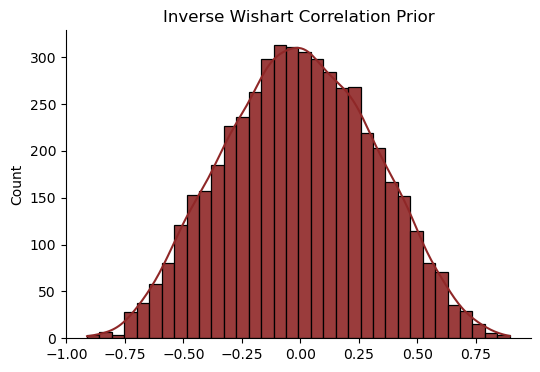

In [3]:
Q = stats.invwishart.rvs(df=10, scale=np.identity(2), size=5000)
corrs = Q[:, 0, 1] / (np.sqrt(Q[:, 0, 0] * Q[:, 1, 1]))
f, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.histplot(corrs, kde=True, color="#8f2727", alpha=0.9, ax=ax)
ax.set_title("Inverse Wishart Correlation Prior")
sns.despine(ax=ax)

We now follow the same steps as in [part 1](./Model_Comparison_MPT.ipynb) to translate our prior into code:

In [4]:
PARAM_NAMES = [r"$\mu_d$", r"$\mu_g$", r"$\Sigma_{00}$", r"$\Sigma_{01}$", r"$\Sigma_{10}$", r"$\Sigma_{11}$"]
RNG = np.random.default_rng(2023)

In [5]:
def hierarchical_prior_fun(rng=None):
    """Samples a random parameter configuration from the hierarchical prior distribution."""

    if rng is None:
        rng = np.random.default_rng()

    mu_d = rng.normal(0, 0.25)
    mu_g = rng.normal(0, 0.25)
    Q = stats.invwishart.rvs(df=10, scale=np.identity(2), random_state=rng)
    lambdas = rng.uniform(0, 3, size=2)
    sigma = np.matmul(np.matmul(np.diag(lambdas), Q), np.diag(lambdas))
    return np.concatenate([np.r_[mu_d, mu_g], sigma.flatten()])

In [6]:
prior = bf.simulation.Prior(prior_fun=hierarchical_prior_fun, param_names=PARAM_NAMES)
prior(batch_size=1)

{'prior_draws': array([[ 0.33133578, -0.15124493,  0.19373801, -0.0171947 , -0.0171947 ,
          1.20265298]]),
 'batchable_context': None,
 'non_batchable_context': None}

### Creating the Simulators

At this point, it is important to stress again our new definition of a data set: In [Part 1](./Model_Comparison_MPT.ipynb), we analyzed participants separately, so each data set contained a single participant. With hierarchical models, we can now take all of our experimental data simultaneously into consideration, so each data set contains several participants with nested observations each. We could also have other hierarchical models, such as students nested into classes or employees nested into organizations, so we refer to the higher order units with the general term *groups*. For this tutorial, we consider a scenario with 50 participants performing 100 trials each.

We continue our known workflow by first specifying simulator functions, then creating our generative models with the ``GenerativeModel`` wrapper and finally combining them with the ``MultiGenerativeModel`` wrapper.

In [7]:
N_GROUPS = 50
N_OBS = 100

In [8]:
def hierarchical_mpt_simulator(theta, model, num_groups, num_obs, rng=None, *args):
    """Simulates data from a hierarchical 1HT or 2HT MPT model, assuming equal proportions of old and new stimuli.

    Parameters
    ----------
    theta      : np.ndarray of shape (num_parameters, )
        Contains draws from the prior distribution for each parameter.
    model      : str, either "1HT" or "2HT"
        Decides the model to generate data from.
    num_groups : int
        The number of groups (participants).
    num_obs    : int
        The number of observations (trials) per group.

    Returns
    -------
    X     : np.ndarray of shape (num_groups, num_obs, 2)
        The generated data set. Contains two columns:
            1. Stimulus type (0="new", 1="old")
            2. Response (0="new", 1="old")
    """

    if rng is None:
        rng = np.random.default_rng()

    obs_per_condition = int(np.ceil(num_obs / 2))

    mu_d, mu_g = theta[:2]
    sigma = np.reshape(theta[2:], (2, 2))

    # Draw vectors containing individual parameters and transform to probabilities
    params = rng.multivariate_normal([mu_d, mu_g], sigma, size=num_groups)
    d = stats.norm.cdf(params[:, 0])
    g = stats.norm.cdf(params[:, 1])

    # Compute category probabilities per model
    if model == "1HT":
        p_11 = d + (1 - d) * g
        p_10 = (1 - d) * (1 - g)
        p_01 = g
        p_00 = 1 - g

    if model == "2HT":
        p_11 = d + (1 - d) * g
        p_10 = (1 - d) * (1 - g)
        p_01 = (1 - d) * g
        p_00 = d + (1 - d) * (1 - g)

    # Assert that category probabilities sum to 1
    assert np.all(np.isclose((p_11 + p_10, p_01 + p_00), 1)), "Category probabilities do not sum to 1!"

    # Create vectors of stimulus types
    stims_single = np.repeat([[1, 0]], repeats=obs_per_condition, axis=1)  # For 1 participant
    stims_data_set = np.repeat(stims_single, repeats=num_groups, axis=0)  # For all participants

    # Simulate responses
    resp_1 = rng.binomial(n=1, p=p_11, size=(obs_per_condition, num_groups)).T
    resp_0 = rng.binomial(n=1, p=p_01, size=(obs_per_condition, num_groups)).T
    resp = np.concatenate((resp_1, resp_0), axis=1)

    # Create final data set
    data = np.stack((stims_data_set, resp), axis=2)

    return data

In [9]:
model_1ht = bf.simulation.GenerativeModel(
    prior=prior,
    simulator=partial(hierarchical_mpt_simulator, model="1HT", num_groups=N_GROUPS, num_obs=N_OBS),
    name="1HT",
    simulator_is_batched=False,
)

model_2ht = bf.simulation.GenerativeModel(
    prior=prior,
    simulator=partial(hierarchical_mpt_simulator, model="2HT", num_groups=N_GROUPS, num_obs=N_OBS),
    name="2HT",
    simulator_is_batched=False,
)

INFO:root:Performing 2 pilot runs with the 1HT model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 50, 100, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing 2 pilot runs with the 2HT model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 50, 100, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


We added the *group* dimension to our data sets, so we now have our data in a 4-dimensional format with the shape (number of data sets, number of groups/participants, number of observations, number of variables):

In [10]:
model_output = model_1ht(batch_size=5)
print("Shape of data batch:", model_output["sim_data"].shape)
print("First 3 rows of first 2 participants in first data set:")
print(model_output["sim_data"][0, :2, :3, :])

Shape of data batch: (5, 50, 100, 2)
First 3 rows of first 2 participants in first data set:
[[[1 1]
  [1 1]
  [1 0]]

 [[1 0]
  [1 1]
  [1 1]]]


In [11]:
meta_model = bf.simulation.MultiGenerativeModel([model_1ht, model_2ht])

### Prior Predictive Checks

The interplay between parameters on several levels adds more complexity to the behavior of hierarchical models. Therefore, prior predictive or pushfoward checks become even more crucial for inspecting whether the chosen parametrization matches one's expectations. Our simulated data sets now contain ``NUM_GROUPS`` participants and ``NUM_OBS`` observations each. If we want to simulate 1000 participants as in [Part 1](./Model_Comparison_MPT.ipynb), we now need only 20 simulations from a model, as each data set contains 50 participants. Afterwards, we calculate the hit rates and false alarm rates for each simulated participant as before and plot them. 

In [12]:
# 1. Data simulation from each model
sim_pfcheck_1ht = model_1ht(batch_size=20)
sim_pfcheck_2ht = model_2ht(batch_size=20)

In [13]:
# 2. Summary statistics
def get_rates(sim_data):
    """Get the hit rate and false alarm rate per participant for each data set in a batch
    of hierarchical data sets simulating binary decision (recognition) tasks.
    Assumes first half of data to cover old items and second half to cover new items."""

    obs_per_condition = int(np.ceil(sim_data.shape[-2] / 2))
    hit_rates = np.mean(sim_data[..., :obs_per_condition, 1], axis=2)
    fa_rates = np.mean(sim_data[..., obs_per_condition:, 1], axis=2)

    return hit_rates, fa_rates


rates_1htm = get_rates(sim_pfcheck_1ht["sim_data"])
rates_2htm = get_rates(sim_pfcheck_2ht["sim_data"])
rates = [rates_1htm, rates_2htm]

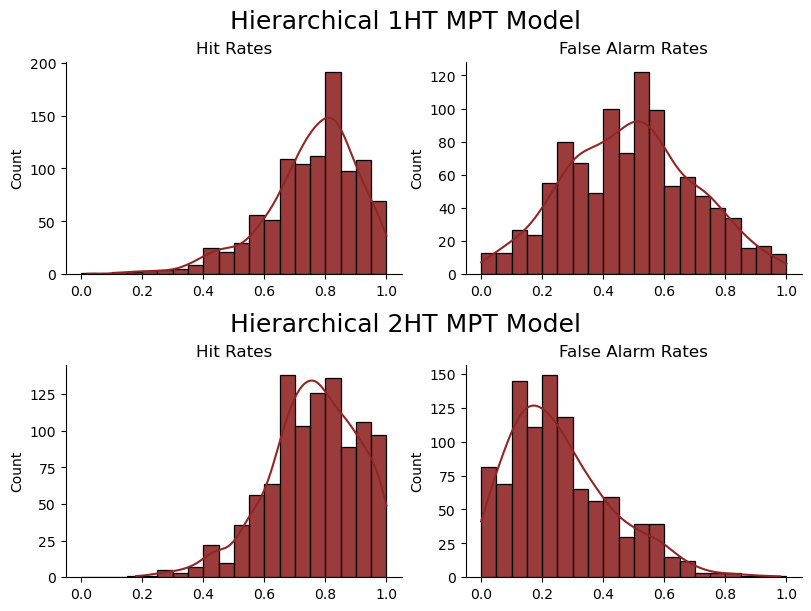

In [14]:
# 3a. Plot rates across all data sets
fig = plt.figure(constrained_layout=True, figsize=(8, 6))
subfigs = fig.subfigures(nrows=2, ncols=1)
model_names = ["Hierarchical 1HT MPT Model", "Hierarchical 2HT MPT Model"]
num_bins = 20
bins = np.linspace(0.0, 1.0, num_bins + 1)

for row, subfig in enumerate(subfigs):
    subfig.suptitle(model_names[row], fontsize=18)
    axs = subfig.subplots(nrows=1, ncols=2)
    sns.histplot(rates[row][0].flatten(), bins=bins, kde=True, color="#8f2727", alpha=0.9, ax=axs[0]).set(
        title="Hit Rates"
    )
    sns.histplot(rates[row][1].flatten(), bins=bins, kde=True, color="#8f2727", alpha=0.9, ax=axs[1]).set(
        title="False Alarm Rates"
    )
sns.despine()

If we plot our 1000 participants over all data sets, we see simular patterns as in [Part 1](./Model_Comparison_MPT.ipynb). Let's additionally take a look at the patterns within the simulated data sets to ensure that the variability between data sets is reasonable:

In [15]:
sns.__version__

'0.12.2'

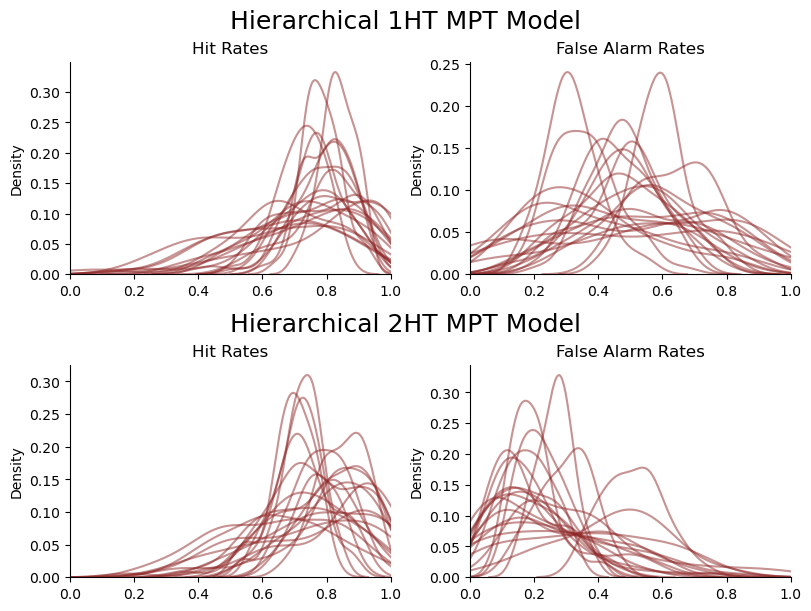

In [16]:
# 3b. Plot rates for each data set
fig = plt.figure(constrained_layout=True, figsize=(8, 6))
subfigs = fig.subfigures(nrows=2, ncols=1)
palette = ["#8f2727"] * rates_1htm[0].shape[0]

for row, subfig in enumerate(subfigs):
    subfig.suptitle(model_names[row], fontsize=18)
    axs = subfig.subplots(nrows=1, ncols=2)
    [ax.set_xlim([0, 1]) for ax in axs]
    sns.kdeplot(rates[row][0].T, alpha=0.5, palette=palette, legend=False, ax=axs[0]).set(title="Hit Rates")
    sns.kdeplot(rates[row][1].T, alpha=0.5, palette=palette, legend=False, ax=axs[1]).set(title="False Alarm Rates")
sns.despine()

We observe some variability but not completely opposing patterns between our simulated data sets. This matches the expectations that we would have when collecting multiple data sets in the field.

## Defining, Training & Validating the Neural Approximator

We adapt the neural network architecture to this new symmetry by changing only a single part, the summary network. We now use a ``HierarchicalNetwork`` which we pass one summary network for each level. The majority of hierarchical models in cognitive modeling assume IID data on all levels, so we simply use one ``DeepSet`` network for each level. If we would have, for instance, temporal dependencies within each participant, we would exchange the first network to one that is specialized for processing time series data, such as a ``TimeSeriesTransformer``.

After this adjustment, all subsequent elements of the training and validation process stay the same as in [Part 1](./Model_Comparison_MPT.ipynb).

In [17]:
summary_net = bf.summary_networks.HierarchicalNetwork([bf.networks.DeepSet(), bf.networks.DeepSet()])
inference_net = bf.inference_networks.PMPNetwork(num_models=2)
amortizer = bf.amortizers.AmortizedModelComparison(inference_net, summary_net)

In [18]:
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=meta_model)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Note: Online learning will be a bit slow to due slow data generation, but still worth it due to amortization. :-) In practice, you would train longer than just $3$ epochs.

In [19]:
losses = trainer.train_online(epochs=3, iterations_per_epoch=100, batch_size=64)

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

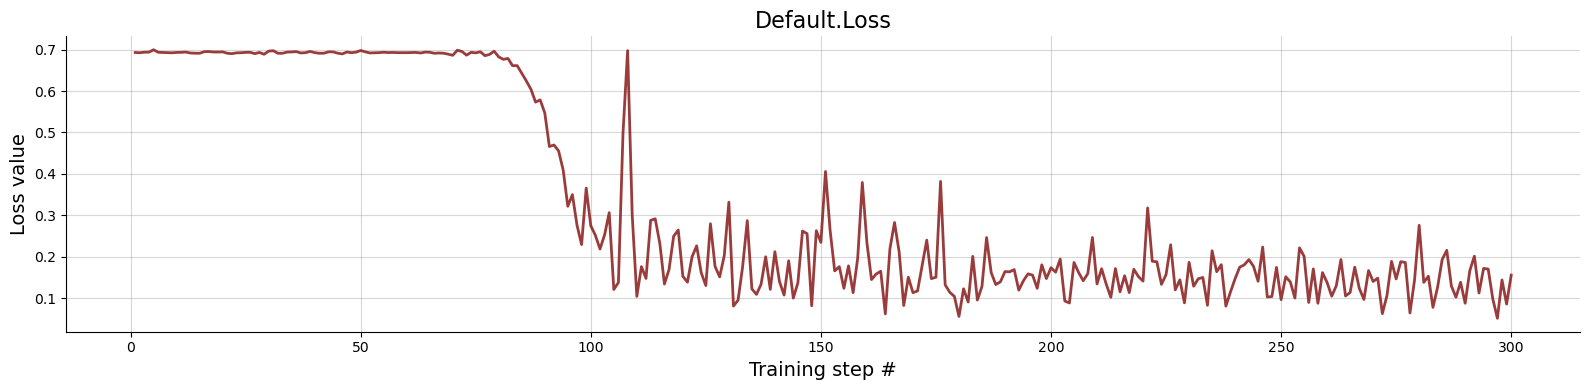

In [20]:
diag_plot = bf.diagnostics.plot_losses(train_losses=losses)

In [21]:
# Generate some validation data in a list to avoid memory troubles during evaluation
sim_data = [trainer.configurator(meta_model(50)) for _ in range(20)]

# Get true indices and predicted PMPs from the trained network
sim_indices = np.concatenate([s["model_indices"] for s in sim_data])

# Estimate model probs in a loop
model_probs = np.concatenate([amortizer.posterior_probs(s) for s in sim_data])

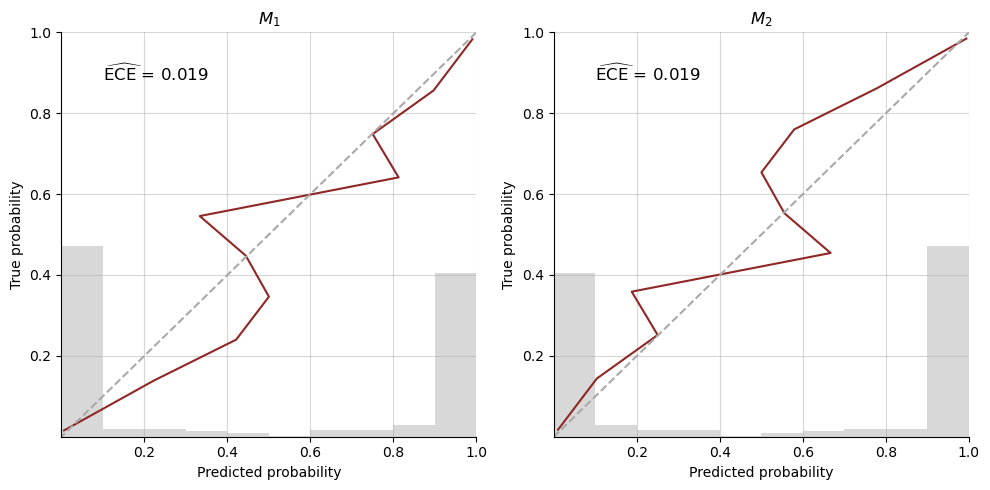

In [22]:
cal_curves = bf.diagnostics.plot_calibration_curves(sim_indices, model_probs)

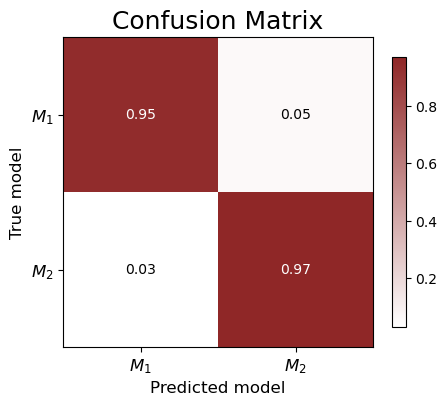

In [23]:
fig = bf.diagnostics.plot_confusion_matrix(sim_indices, model_probs)

Our neural network quickly learned to discriminate between the two hierarchical models and shows excellent performance when validated on simulated data. The calibration curves look a bit shaky, but the marginal bin histograms tell us that this is due to the majority of the predicted probabilities being close to 0 or 1, leaving the middle ('uncertain') bins quite abandonded.

## Network Application

As in [Part 1](./Model_Comparison_MPT.ipynb), we apply our trained model to a synthetic data set from the **2HT** model. We again redefine our simulator with fixed random seeds for reproducible results:

In [24]:
prior_fixed = bf.simulation.Prior(
    prior_fun=partial(hierarchical_prior_fun, rng=np.random.default_rng(2023)), param_names=PARAM_NAMES
)
fake_data_generator = bf.simulation.GenerativeModel(
    prior=prior_fixed,
    simulator=partial(
        hierarchical_mpt_simulator, model="2HT", num_groups=N_GROUPS, num_obs=N_OBS, rng=np.random.default_rng(2023)
    ),
    skip_test=True,
    simulator_is_batched=False,
)

fake_data = fake_data_generator(batch_size=1)["sim_data"]
print(fake_data.shape)

(1, 50, 100, 2)


We can inspect our simulated data set by looking at hit and false alarm rates for each of our 50 participants. This is best done visually:

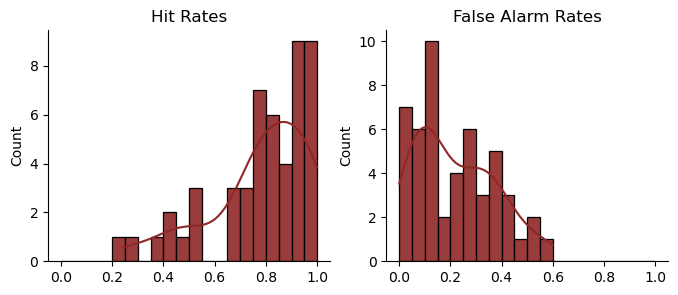

In [25]:
rates = get_rates(fake_data)
f, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.histplot(rates[0].flatten(), bins=bins, kde=True, color="#8f2727", alpha=0.9, ax=ax[0]).set(title="Hit Rates")
sns.histplot(rates[1].flatten(), bins=bins, kde=True, color="#8f2727", alpha=0.9, ax=ax[1]).set(
    title="False Alarm Rates"
)
sns.despine()

As in [part 1](./Model_Comparison_MPT.ipynb), our data set contains many participants with low false alarm rates, which are unlikely under the 1HT model. Let's see the evidence contained in our simulated data:

In [26]:
embeddings = summary_net(fake_data)
preds = inference_net.posterior_probs(embeddings)[0]
preds

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.00307983, 0.9969202 ], dtype=float32)>

In [27]:
bayes_factor12 = preds[0] / preds[1]
bayes_factor12

<tf.Tensor: shape=(), dtype=float32, numpy=0.003089342>

Our Bayesian model comparison reveals clear evidence for the 2HT model, much more decisive than in [Part 1](./Model_Comparison_MPT.ipynb). While the unambiguousness of the results depends, of course, on the model specification and the randomly simulated data, our model comparison now contains $50$ times more data by considering all participants simultaneously!